# `multidms` fitting pipeline

Here, we demonstrate the pipeline for fitting a `multidms` model on some data using the tools available in the package. Currently, we show how to pre-process data from various dms experiments targeting Delta and Omicron spike protein homologs.

In [1]:
# built-in libraries
import os
import sys
import pickle
from itertools import combinations
import importlib
import math
import re
from timeit import default_timer as timer
import json

# external dependencies
import pandas as pd
import jax
import jax.numpy as jnp
from jax.experimental import sparse
from jaxopt import ProximalGradient
import jaxopt
import numpy as onp
from scipy.stats import pearsonr
import binarymap as bmap
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine

# local dependencies
sys.path.append("..")
import multidms

**First, we'll define a few global variables.**

In [2]:
# The substitution column to use from the functional score dataframes
substitution_column = 'aa_substitutions_reference'

# The column providing which individual conditions each variant observation was derived from.
experiment_column = 'homolog_exp'

**Define all the knobs which define the pipeline's behavior**

In [6]:
fit_params = {
    # pre-processing params
    "scale_counts" : False,
    "fs_scaling_group_column" : "homolog_exp",
    "min_pre_counts" : 100,
    "pseudocount" : 0.1,
    "agg_variants" : True,
    "sample" : False, # 10000,
    "min_pre_counts" : 100,
    "clip_target" : (-3.5, 2.5),
    "include_stop_variants" : True,
    "shift_func_score_target_nonref" : False,
    # conditions to include in fit
    "reference_condition" : "Delta-2-1",
    "conditions" : ["Delta-2-1", "Omicron_BA.1-2-1"],
    # fitting hyper-parameters
    "maxiter" : 10000,
    "λ_lasso" : 1e-5,
    "λ_ridge" : 0,
    "model" : "non-linear",
    "lower_bound" : -3.5,
    "hinge_scale" : 2.0
}

**Define the attributes you'll have access to after each fit**

In [7]:
cols = list(fit_params.keys()) + [
    "tuned_model_params", "mutation_effects_df", "variant_prediction_df", "site_map"
]

**uncomment if you want to reset all results, or if this is the first run**

In [8]:
results = pd.DataFrame(columns = cols)

## Pre-Proccessing

**Read in the dms data and list all available experimental conditions**

In [9]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA.1", "Omicron_BA.2"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../results/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../results/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['homolog_exp'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,homolog_exp
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1-2
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-1
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-2
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4-1
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4-2
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-1
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-2
8,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1-1
9,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1-2


**Query the conditions to be included in a fit**

In [10]:
func_score_data = func_score_data.query(
    f"{experiment_column}.isin({fit_params['conditions']})"
)
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,homolog_exp
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-1
10,2022-06-22_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2022-06-22_thaw-1_no-antibody_control_1,Lib-2_2022-06-22_thaw-1_VSVG_control_1,Lib-2_2022-06-22_thaw-1_no-antibody_control_1,Lib-2_2022-06-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-2_2022-06-22_thaw-...,library pre_samp...,140643,Omicron_BA.1,Omicron_BA.1-2-1


In [11]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data.iterrows(), total=len(func_score_data)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(homolog_exp=row.homolog_exp)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])

  0%|          | 0/2 [00:00<?, ?it/s]

**Optionally subset the variants**

In [12]:
if fit_params["sample"]:
    func_score_df = func_score_df.sample(fit_params["sample"])

**remove all variants with string sites and stop codon wildtypes**

In [13]:
func_score_df.aa_substitutions_reference.fillna("", inplace=True)
gapped_sub_vars = []
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    if "-" in row[substitution_column]:
        gapped_sub_vars.append(idx)
    for sub in row[substitution_column].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(gapped_sub_vars), set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/182229 [00:00<?, ?it/s]

**Optionally, scale the counts**

In [14]:
# TODO re-write and make function
# def normalize_by_freq()?
if fit_params['scale_counts']:
    dfs = []
    for (h, hdf) in func_score_df.groupby(fit_params["fs_scaling_group_column"]):
        n_post_counts = sum(hdf['post_count'])
        if 'Delta' in h:
            bottleneck = 1e5
            scaling_factor = bottleneck / n_post_counts # scaling_factor = 0.05
        else:
            bottleneck = 1e5
            scaling_factor = bottleneck / n_post_counts # scaling_factor = 0.05
        hdf['orig_post_count'] = hdf['post_count']
        hdf['post_count'] *= scaling_factor
        hdf['post_count_wt'] *= scaling_factor
        print(h, n_post_counts, round(scaling_factor, 2), round(sum(hdf['post_count']),2))

        # Recompute enrichment ratios with new counts
        hdf['pre_count_ps'] = hdf['pre_count'] + fit_params["pseudocount"]
        hdf['post_count_ps'] = hdf['post_count'] + fit_params["pseudocount"]
        hdf['pre_count_wt_ps'] = hdf['pre_count_wt'] + fit_params["pseudocount"]
        hdf['post_count_wt_ps'] = hdf['post_count_wt'] + fit_params["pseudocount"]

        total_pre_count = sum(hdf['pre_count_ps'])
        total_post_count = sum(hdf['post_count_ps'])

        hdf['pre_freq'] = hdf['pre_count_ps'] / total_pre_count
        hdf['post_freq'] = hdf['post_count_ps'] / total_post_count
        hdf['pre_freq_wt'] = hdf['pre_count_wt_ps'] / total_pre_count
        hdf['post_freq_wt'] = hdf['post_count_wt_ps'] / total_post_count

        hdf['wt_e'] = hdf['post_freq_wt'] / hdf['pre_freq_wt']
        hdf['var_e'] = hdf['post_freq'] / hdf['pre_freq']
        hdf['e'] = hdf['var_e'] / hdf['wt_e']
        #hdf.dropna(subset=['e'], inplace=True)
        hdf['func_score'] = hdf['e'].apply(lambda x: math.log(x, 2))
        dfs.append(hdf)
    func_score_df = pd.concat(dfs)

**Drop all variants with pre-counts below a threshold.**

In [15]:
# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
func_score_df = func_score_df[func_score_df['pre_count'] >= fit_params["min_pre_counts"]]
print(f"Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than {fit_params['min_pre_counts']} counts before selection, and were filtered out")

Of 169856 variants, 16326 had fewer than 100 counts before selection, and were filtered out


**Optionally throw all variants with stop codons.**

In [16]:
# results["include_stop_variants"] = True
if not fit_params["include_stop_variants"]:
    stop_variants = [idx for idx, row in func_score_df.iterrows() if "*" in row[substitution_column]]
    func_score_df = func_score_df.drop(stop_variants)

**Optionally, aggregate variant functional scores across barcode replicates**

In [17]:
if fit_params["agg_variants"]:
    func_score_df = func_score_df.groupby([substitution_column, experiment_column]).mean().reset_index()
func_score_df["pre_count"] = func_score_df["pre_count"].astype(int)
func_score_df["post_count"] = func_score_df["post_count"].astype(int)

**Optionally, clip the target functional scores**

In [18]:
if fit_params['clip_target']:
    func_score_df["func_score"] = func_score_df["func_score"].clip(*fit_params["clip_target"])

## Prep the data for model fit

**From the functional score dataframe, we prep the modeling data**
1. (X, y) - the sparse-binarymap and target jax ndarrays for training. Both X and y are dictionaries with entries for each of the conditions.
2. df - the functional score dataframe which has been curated to include only shared sites between conditions and adds the variant substitutions string with respect to the reference condition.
3. All the substitutions given in the order which parameters are assigned (i.e. their column index into X)
4. The site map for all inferred wildtype aa at each site in the dataset.

In [19]:
importlib.reload(multidms.utils)

# multidms = importlib.reload(multidms)
(X, y), df, all_subs, site_map = multidms.utils.create_homolog_modeling_data(
                            func_score_df, 
                            experiment_column,
                            fit_params["reference_condition"],
                            substitution_column,
                            "func_score"
                        )

sig_upper = df["func_score"].quantile(0.95)
sig_lower = df["func_score"].quantile(0.05)
sig_range = sig_upper - sig_lower

Found 11 site(s) lacking data in at least one homolog.
2766 of the 93822 variants were removed because they had mutations at the above sites, leaving 91056 variants.


100%|██████████████████████████████████████████████████| 66785/66785 [02:12<00:00, 502.53it/s]


There were 0 cache hits in total for homolog Omicron_BA.1-2-1.


**Initialize parameters for the model**

In [20]:
# Initialize all params
params = multidms.utils.initialize_model_params(
    func_score_df[experiment_column].unique(), 
    n_beta_shift_params=X[fit_params['reference_condition']].shape[1],
    include_alpha=True if fit_params["model"] == "non-linear" else False,
    init_sig_range=sig_range,
    init_sig_min=sig_lower
)
params

{'β': DeviceArray([ 1.83095432, -0.50997419,  0.79581333, ..., -0.14361239,
              -0.20343108, -1.30266273], dtype=float64),
 'S_Delta-2-1': DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
 'C_Delta-2-1': DeviceArray([0.], dtype=float64),
 'γ_Delta-2-1': DeviceArray([0.], dtype=float64),
 'S_Omicron_BA.1-2-1': DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
 'C_Omicron_BA.1-2-1': DeviceArray([0.], dtype=float64),
 'γ_Omicron_BA.1-2-1': DeviceArray([0.], dtype=float64),
 'α': {'ge_scale': DeviceArray([4.307925], dtype=float64),
  'ge_bias': DeviceArray([-3.5], dtype=float64)},
 'C_ref': DeviceArray([5.], dtype=float64)}

In [36]:
importlib.reload(multidms.model)
cost_func = multidms.model.cost_smooth
prox_func = multidms.model.prox
pred_func = multidms.model.f
if fit_params["model"] == "linear":
    cost_func = multidms.model.cost_smooth_linear
    pred_func = multidms.model.f_linear

## Fit the model

In [37]:
print(f"\nPre-Optimization")
print(f"----------------")
pred = cost_func(
    params, 
    data=(X, y),
    λ_ridge=fit_params['λ_ridge'],
    lower_bound=fit_params['lower_bound'], 
    hinge_scale=fit_params['hinge_scale']
)
print(f"cost = {pred:.2e}")


Pre-Optimization
----------------
cost = 4.85e-01


In [38]:
# reference_condition

In [39]:
tol = 1e-6
start = timer()

# initialize a solver
solver = ProximalGradient(
    cost_func,
    prox_func, 
    tol=tol, 
    maxiter=fit_params['maxiter']
)

# the reference shift and gamma parameters forced to be zero
lock_params = {
    f"S_{fit_params['reference_condition']}" : jnp.zeros(len(params['β'])),
    f"γ_{fit_params['reference_condition']}" : jnp.zeros(shape=(1,)),
}

# currently we lock C_h because of odd model behavior
for condition in fit_params['conditions']:
    lock_params[f"C_{condition}"] = jnp.zeros(shape=(1,))

# lasso regularization on the Shift parameters
lasso_params = {}
for non_ref_condition in fit_params['conditions'][1:]:
    lasso_params[f"S_{non_ref_condition}"] = fit_params['λ_lasso']

# run the optimizer
print('Fitting model')
params, state = solver.run(
    params,
    hyperparams_prox = dict(
        lasso_params = lasso_params,
        lock_params = lock_params
    ),
    data=(X, y),
    λ_ridge=fit_params['λ_ridge'],
    lower_bound=fit_params['lower_bound'],
    hinge_scale=fit_params['hinge_scale']
)
end = timer()

# evaluate
print(f"\nPost-Optimization")
print(f"-----------------")
print(f"Full model optimization: {state.iter_num} iterations")
print(f"error = {state.error:.2e}")
pred = cost_func(
    params, 
    (X, y), 
    λ_ridge=fit_params['λ_ridge'], 
    lower_bound=fit_params['lower_bound'], 
    hinge_scale=fit_params['hinge_scale']
)
print(f"cost = {pred:.2e}")
print(f"Wall time for fit: {end - start}")
print(f"\nDONE :)")
print(f"-------------------")

Fitting model

Post-Optimization
-----------------
Full model optimization: 10000 iterations
error = 2.84e-04
cost = 4.78e-01
Wall time for fit: 127.43660113681108

DONE :)
-------------------


**Create all single mutant effects dataframe**

In [45]:
df["predicted_latent_phenotype"] = onp.nan
df[f"predicted_func_score"] = onp.nan
df[f"corrected_func_score"] = df[f"func_score"]

print(f"\nRunning Predictions")
print(f"-------------------")

# sub string, wt, site, mut, Beta, {S_c}, {F_c}
# TODO number of times seen?

mut_effect_df = pd.DataFrame({
    "substitution" : all_subs,
    "β" : params["β"]
})

mut_effect_df["wt"], mut_effect_df["site"], mut_effect_df["mut"] = zip(
  *mut_effect_df["substitution"].map(multidms.utils.split_sub)
)

binary_single_subs = sparse.BCOO.fromdense(onp.identity(len(all_subs)))

for homolog, hdf in df.groupby(experiment_column):
    
    # collect relevant params
    h_params = {
        "β":params["β"], 
        "C_ref":params["C_ref"],
        "S":params[f"S_{homolog}"], 
        "C":params[f"C_{homolog}"],
        "γ":params[f"γ_{homolog}"]
    }
    
    if fit_params["model"] == "non-linear": h_params["α"] = params["α"]
    
    # latent predictions on all variants
    z_h = multidms.model.ϕ(h_params, X[homolog])
    df.loc[hdf.index, "predicted_latent_phenotype"] = z_h

    # full model predictions
    y_h_pred = pred_func(
        h_params, 
        X[homolog], 
        lower_bound=fit_params['lower_bound'], 
        hinge_scale=fit_params['hinge_scale'],
    )
    df.loc[hdf.index, f"predicted_func_score"] = y_h_pred
    
    # add the corrected functional scores by tuned gamma
    df.loc[hdf.index, f"corrected_func_score"] += h_params[f"γ"]
    
    # attach relevent params to mut effects df
    mut_effect_df[f"S_{homolog}"] = params[f"S_{homolog}"]
    
    # predictions for all single subs
    mut_effect_df[f"F_{homolog}"] = pred_func(
        h_params, 
        binary_single_subs, 
        lower_bound=fit_params['lower_bound'], 
        hinge_scale=fit_params['hinge_scale'],
    )

row = fit_params.copy()

row["variant_prediction_df"] = df.drop("index", axis=1)
row["mutation_effects_df"] = mut_effect_df
row["site_map"] = site_map.copy()
row["tuned_model_params"] = params.copy()

# results = pd.Series(row)
results.loc[len(results)] = pd.Series(row)

print(f"\nDONE :)")
print(f"-------------------")


Running Predictions
-------------------

DONE :)
-------------------


In [46]:
results.loc[:, [
    "agg_variants", 
    "clip_target",
    "hinge_scale",
    "lower_bound",
    "scale_counts", 
    "model", 
    "conditions"
    ]]

,agg_variants,clip_target,hinge_scale,lower_bound,scale_counts,model,conditions
0,True,"(-3.5, 2.5)",2.0,-3.5,False,non-linear,"[Delta-2-1, Omicron_BA.1-2-1]"


## Visualize results

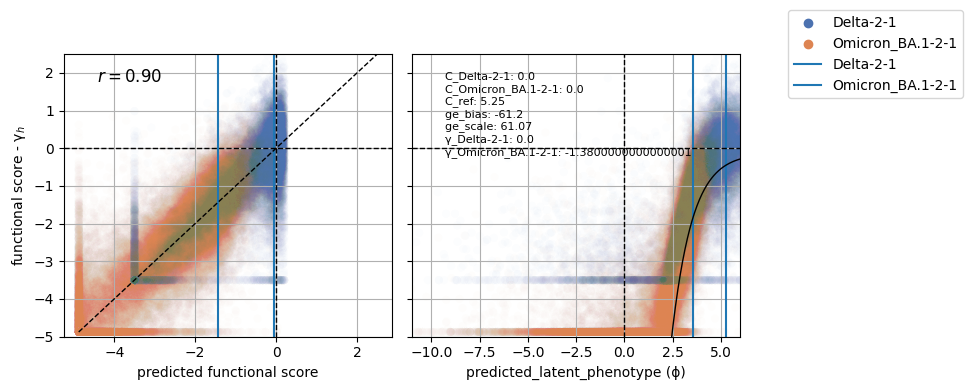

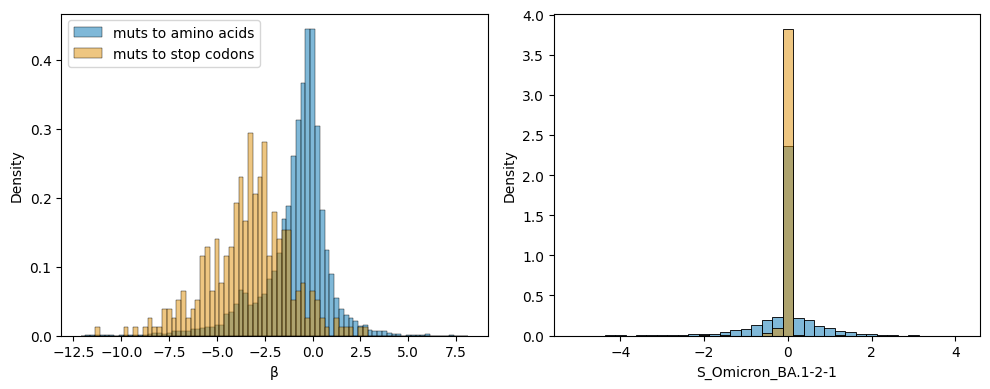

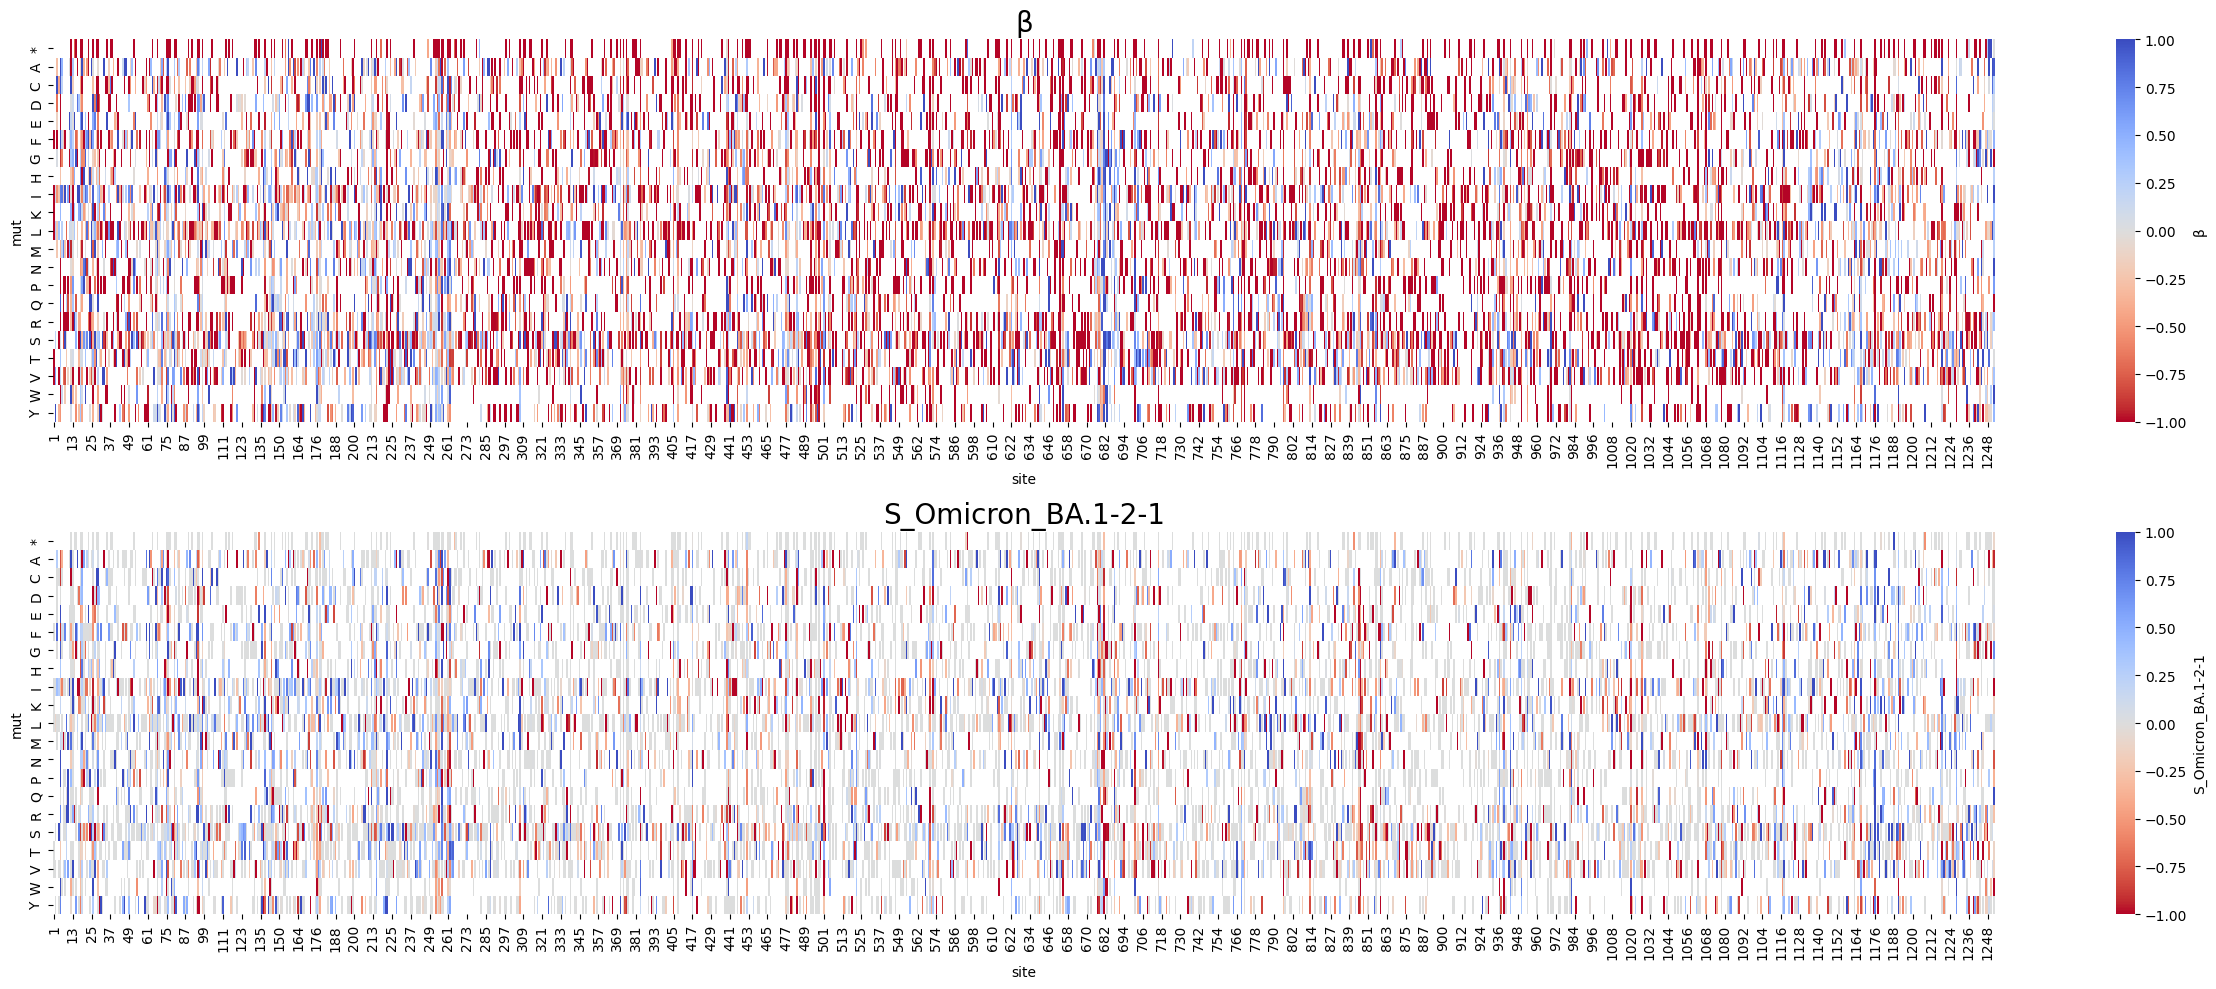

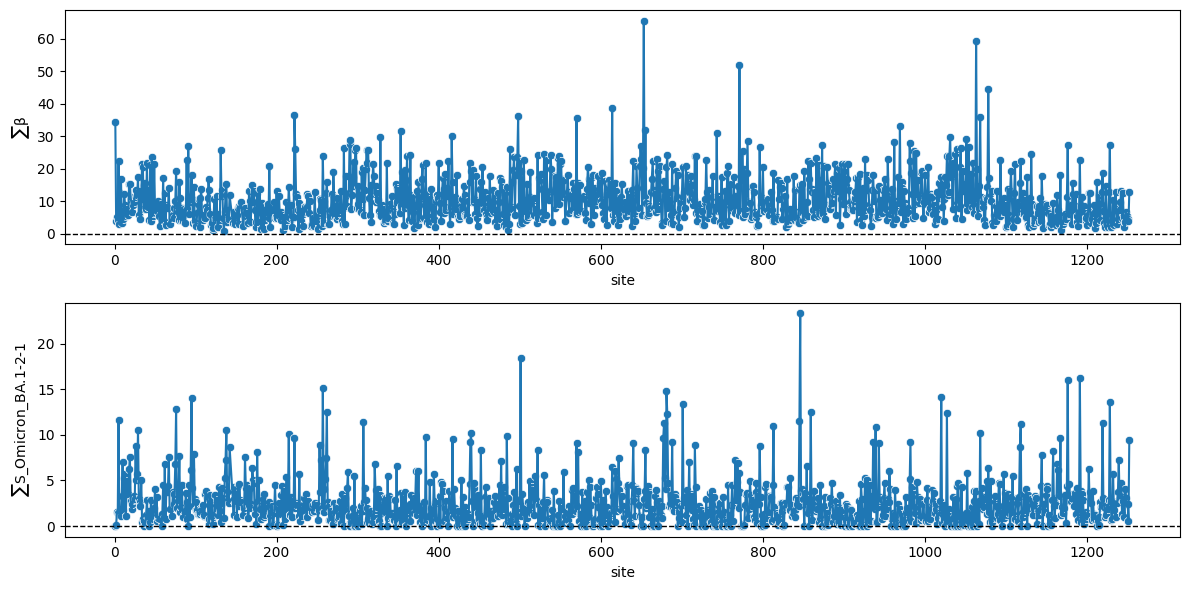

In [48]:
importlib.reload(multidms.plot)
exps = [0]
res = results.loc[exps, :]
# res = results.loc[len(results)-1:len(results), :]

multidms.plot.plot_pred_scatter(
    res, 
    #annotation_vars=list(fit_params.keys()), 
    hue=True, 
    printrow=False,
    annotate_params=True,
)
multidms.plot.plot_param_hist(
    res,
    printrow=False
)
multidms.plot.plot_param_heatmap(
    res, 
    printrow=False
)
multidms.plot.plot_param_by_site(
    res, 
    printrow=False
)
# multidms.plot.plot_fit_param_comp_scatter(
#     res, 
#     {0:"β", 1:"β"}
# )
# multidms.plot.plot_fit_param_comp_scatter(
#     res, 
#     {2:"S_Omicron_BA.1-2-1", 3:"S_Omicron_BA.1-3-1"}
# )